# Average price by room type and City Hall

Our main goal will be to find the average price of an [Airbnb](https://es-l.airbnb.com/) accommodation offered by room type among the 16 City Halls in Mexico city and visualize this data on an interactive map.

All accommodation offered in Airbnb is required to be as one of these room types:

* Entire home/apartment
* Hotel room	
* Private room	
* Shared room

By calculating the average price for one of each of this room types by City Hall, we will be able to find the expensive and cheapper City Hall to get an Airbnb accommodation by room type.

Additionally, we will try to find out if there is a relationship between how long the host has been and his score rating.

The results are displayed in [seaborn](https://seaborn.pydata.org/) plots and interactive maps using [folium](https://github.com/python-visualization/folium) to plot geospacial data.

### References:
* [Geospatial Analysis using Folium](https://www.analyticsvidhya.com/blog/2020/06/guide-geospatial-analysis-folium-python/)
* [GeoJson Popup and Tooltip](https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/GeoJsonPopupAndTooltip.ipynb)
* [Interactive Map visualization with Folium in Python](https://medium.com/@saidakbarp/interactive-map-visualization-with-folium-in-python-2e95544d8d9b)

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas
import branca
from geopandas import GeoDataFrame
from folium.features import GeoJson, GeoJsonTooltip

### Importing the dataset

Previously we have imported and cleaned the dataset available from [Airbnb Datasets](http://insideairbnb.com/get-the-data.html). 

Clean data set can be found in the project repository [here.](https://github.com/prope-2020-gh-classroom/practica-final-por-equipos-verano-2020-itam-EddOselotl/blob/master/airbnb_clean.csv)

In [2]:
geojson = "https://raw.githubusercontent.com/prope-2020-gh-classroom/practica-final-por-equipos-verano-2020-itam-EddOselotl/master/neighbourhoods.geojson"
geop = geopandas.read_file(geojson)

In [95]:
df = pd.read_csv("https://raw.githubusercontent.com/prope-2020-gh-classroom/practica-final-por-equipos-verano-2020-itam-EddOselotl/master/airbnb_clean.csv")

In [96]:
df.head()

,Unnamed: 0,id,name,host_id,host_since,host_total_listings_count,latitude,longitude,neighbourhood_cleansed,property_type,room_type,square_feet,price,review_scores_rating
0,0,22787,"Sunny suite w/ queen size bed, inside boutique...",87973,2010-03-03,9,19.44076,-99.16324,Cuauhtémoc,Boutique hotel,Private room,248.0,2331.0,98.0
1,1,35797,Villa Dante,153786,2010-06-28,2,19.38399,-99.27335,Cuajimalpa de Morelos,Villa,Entire home/apt,32292.0,4457.0,NaN
2,2,56074,Great space in historical San Rafael,265650,2010-10-19,2,19.43937,-99.15614,Cuauhtémoc,Condominium,Entire home/apt,646.0,809.0,97.0
3,3,58955,Entire beautiful duplex in la Roma,282620,2010-11-09,1,19.42292,-99.15775,Cuauhtémoc,Loft,Entire home/apt,1184.0,1932.0,100.0
4,4,61792,Spacious Clean Quiet room (own bath) in la Con...,299558,2010-11-26,1,19.41259,-99.17959,Cuauhtémoc,House,Private room,161.0,1364.0,98.0


Using [pandas](https://pandas.pydata.org/) we can easily group our data set by room typ and City Hallcalculate and calculate average with the [mean](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.aggregate.html) function.

In [97]:
### group by saved to a new dataframe
room_type = df.groupby(['room_type','neighbourhood_cleansed'])['price'].mean().reset_index(name='mean_by_room')

A quick look to this plot shows some outliers, so we want to take a look at those to determine if is a real value or we can remove it from our data set

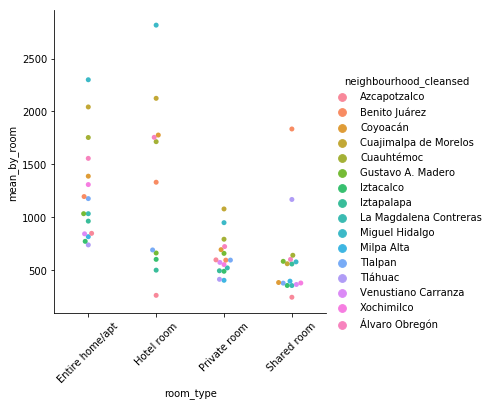

In [98]:
### Plotting the dataframe using seaborn
sns.catplot(x="room_type", y="mean_by_room", hue="neighbourhood_cleansed", kind="swarm", data=room_type).set_xticklabels(rotation=45);

First we want to see what are means on room types where the outliers are present, its clear that in City Halls Xochimilco, Iztapalapa and Cuajimalpa de Morelos the mean for Private rooms accomodations are high above the rest of the City Halls.

In [32]:
room_type.loc[room_type['room_type'] == 'Private room'].describe()

,mean_by_room
count,16.000000
mean,898.706676
std,716.688246
min,404.125000
25%,560.150916
50%,627.868270
75%,831.425898
max,2989.978022


In [33]:
room_type.loc[room_type['room_type'] == 'Private room']

,room_type,neighbourhood_cleansed,mean_by_room
27,Private room,Azcapotzalco,597.183544
28,Private room,Benito Juárez,594.506603
29,Private room,Coyoacán,693.642311
30,Private room,Cuajimalpa de Morelos,1078.395604
31,Private room,Cuauhtémoc,792.286778
32,Private room,Gustavo A. Madero,658.552995
33,Private room,Iztacalco,489.364162
34,Private room,Iztapalapa,2306.748815
35,Private room,La Magdalena Contreras,521.210000
36,Private room,Miguel Hidalgo,948.843255


A closer look to this group demonstrate our hunch. This entry is way above the rest of the metrics for its group, the realtion between the quartiles proves it.

In [78]:
df.loc[(df['room_type'] == 'Private room') & (df['neighbourhood_cleansed'] == 'Iztapalapa')].describe()

,id,host_id,host_total_listings_count,latitude,longitude,square_feet,price,review_scores_rating
count,2.110000e+02,2.110000e+02,211.000000,211.000000,211.000000,0.0,211.000000,104.000000
mean,3.165144e+07,1.920184e+08,2.914692,19.355422,-99.089907,NaN,2306.748815,93.759615
std,1.002449e+07,8.817381e+07,3.592628,0.025454,0.035145,NaN,24173.314196,14.669495
min,1.107979e+06,6.083480e+06,0.000000,19.292300,-99.137850,NaN,178.000000,20.000000
25%,2.460699e+07,1.295018e+08,1.000000,19.338905,-99.123285,NaN,240.000000,95.000000
50%,3.370890e+07,1.962370e+08,1.000000,19.362700,-99.090910,NaN,290.000000,100.000000
75%,4.084703e+07,2.549655e+08,3.000000,19.372155,-99.069415,NaN,434.500000,100.000000
max,4.345904e+07,3.442908e+08,15.000000,19.394280,-98.968570,NaN,350007.000000,100.000000


We need to remove this two top rows from our dataset

In [94]:
df.loc[(df['room_type'] == 'Private room') & (df['neighbourhood_cleansed'] == 'Iztapalapa')].sort_values('price',ascending=False).head()

,id,name,host_id,host_since,host_total_listings_count,latitude,longitude,neighbourhood_cleansed,property_type,room_type,square_feet,price,review_scores_rating
20395,42516153,Cuarto amueblado con lugar de estacionamiento,338600182,2020-02-24,2,19.38550,-99.09180,Iztapalapa,House,Private room,NaN,9838.0,NaN
5604,20167205,Habitación en casa sola (no departamento),114003092,2017-01-30,1,19.35090,-99.11043,Iztapalapa,House,Private room,NaN,6218.0,NaN
11583,31266653,Friducha,233965910,2019-01-02,1,19.33591,-99.03042,Iztapalapa,Guest suite,Private room,NaN,4453.0,NaN
13337,33739711,Habitación con baño en paseos de churubusco,254328883,2019-04-09,1,19.38581,-99.08866,Iztapalapa,Apartment,Private room,NaN,3009.0,NaN
8902,26107409,Habitacion para estudiantes,196236997,2018-06-17,2,19.35412,-99.10033,Iztapalapa,Apartment,Private room,NaN,2006.0,NaN


In [80]:
df.drop(df[df['id'] == 23895520].index, inplace = True)
df.drop(df[df['id'] == 15423429].index, inplace = True)

Now we have a more realistic mean

In [81]:
df.loc[(df['room_type'] == 'Private room') & (df['neighbourhood_cleansed'] == 'Iztapalapa')].describe()

,id,host_id,host_total_listings_count,latitude,longitude,square_feet,price,review_scores_rating
count,2.090000e+02,2.090000e+02,209.000000,209.000000,209.000000,0.0,209.000000,104.000000
mean,3.176620e+07,1.925547e+08,2.933014,19.355460,-99.090525,NaN,494.191388,93.759615
std,9.994404e+06,8.834951e+07,3.604926,0.025491,0.034391,NaN,883.856786,14.669495
min,1.107979e+06,6.083480e+06,0.000000,19.292300,-99.137850,NaN,178.000000,20.000000
25%,2.496753e+07,1.319275e+08,1.000000,19.339280,-99.123320,NaN,240.000000,95.000000
50%,3.373971e+07,1.982955e+08,2.000000,19.362700,-99.091060,NaN,290.000000,100.000000
75%,4.089601e+07,2.556021e+08,3.000000,19.372080,-99.069720,NaN,423.000000,100.000000
max,4.345904e+07,3.442908e+08,15.000000,19.394280,-98.968570,NaN,9838.000000,100.000000


Same procedure for Xochimilco

In [82]:
df.loc[(df['room_type'] == 'Private room') & (df['neighbourhood_cleansed'] == 'Xochimilco')].sort_values('price',ascending=False)

,id,name,host_id,host_since,host_total_listings_count,latitude,longitude,neighbourhood_cleansed,property_type,room_type,square_feet,price,review_scores_rating
14355,35302200,En un lindo pueblito a 20 minutos de Xochimilco .,228126920,2018-11-28,1,19.25915,-99.12908,Xochimilco,Dome house,Private room,NaN,196149.0,NaN
4526,18021063,cuarto tranquilo en el sur del DF,69092379,2016-04-26,1,19.28494,-99.10893,Xochimilco,House,Private room,NaN,26745.0,NaN
13457,33910274,Hermosa Casona Mexicana rodeada de naturaleza.,123228935,2017-03-29,1,19.21312,-99.08606,Xochimilco,Cottage,Private room,NaN,9007.0,100.0
3398,15716008,Charming bedroom for students,78705654,2016-06-19,1,19.27361,-99.13396,Xochimilco,House,Private room,NaN,3722.0,NaN
8214,24494628,Por el momento sin servicio,51710151,2015-12-19,1,19.27570,-99.12872,Xochimilco,Guesthouse,Private room,NaN,3009.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17807,39915849,Habitación privada ideal para estudiar y desca...,11928644,2014-02-04,2,19.27735,-99.14143,Xochimilco,Guest suite,Private room,NaN,201.0,NaN
17549,39610629,Recámara para 1 o 2 personas. Amp. Tepepan.,293230163,2019-09-08,5,19.26830,-99.14307,Xochimilco,House,Private room,NaN,201.0,100.0
14274,35161077,Cómodo alojamiento en el sur de la ciudad,264802819,2019-05-28,3,19.27313,-99.12284,Xochimilco,Apartment,Private room,NaN,201.0,90.0
6654,21957404,Room in Xochimilco.,160294584,2017-11-27,2,19.25879,-99.11703,Xochimilco,House,Private room,NaN,197.0,100.0


In [83]:
df.drop(df[df['id'] == 35302200].index, inplace = True)
df.drop(df[df['id'] == 18021063].index, inplace = True)

And for Cuajimalpa de Morelos. How ever for this case, this outlier doesnt looks to be an error. So we don't remove it from our data set.

In [84]:
df.loc[(df['room_type'] == 'Private room') & (df['neighbourhood_cleansed'] == 'Cuajimalpa de Morelos')].sort_values('price',ascending=False)

,id,name,host_id,host_since,host_total_listings_count,latitude,longitude,neighbourhood_cleansed,property_type,room_type,square_feet,price,review_scores_rating
14828,36026043,SE RENTA CASA,157998765,2017-11-09,2,19.35401,-99.28623,Cuajimalpa de Morelos,House,Private room,NaN,23001.0,NaN
17674,39756753,Suite en penthouse en bosques de las lomas,45328784,2015-09-29,0,19.38589,-99.26453,Cuajimalpa de Morelos,Loft,Private room,NaN,13149.0,100.0
2443,13157322,Rento cuarto amueblado - Santa Fe DF (9000mxn/...,52028301,2015-12-22,1,19.35684,-99.27565,Cuajimalpa de Morelos,Apartment,Private room,NaN,9001.0,NaN
2780,14009995,Residencial Tamarindos Garden house,83753460,2016-07-14,1,19.38485,-99.25279,Cuajimalpa de Morelos,Apartment,Private room,NaN,6686.0,NaN
19621,41857340,Cuarto cómodo en Cuajimalpa,130902813,2017-05-18,3,19.36530,-99.30054,Cuajimalpa de Morelos,Apartment,Private room,NaN,5995.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6129,21108266,"Cuarto de Azotea todos los servicios, Cuajimalpa!",146767657,2017-08-19,1,19.35899,-99.29858,Cuajimalpa de Morelos,Guest suite,Private room,NaN,205.0,80.0
3438,15801741,Cuajimalpa cerca de Santa Fe 2 cuartos 1 dispo...,102243143,2016-11-02,1,19.35827,-99.28956,Cuajimalpa de Morelos,Apartment,Private room,NaN,201.0,100.0
15671,37400787,"Estudia, Trabaja y Diviértete en CDMX - Cuajim...",56873881,2016-01-31,0,19.35129,-99.30078,Cuajimalpa de Morelos,Apartment,Private room,NaN,201.0,100.0
8954,26225318,cuarto independiente pensado para todo viajero,190283296,2018-05-18,5,19.34635,-99.28474,Cuajimalpa de Morelos,House,Private room,NaN,201.0,94.0


Plot again without the outliers

In [85]:
room_type = df.groupby(['room_type','neighbourhood_cleansed'])['price'].mean().reset_index(name='mean_by_room')

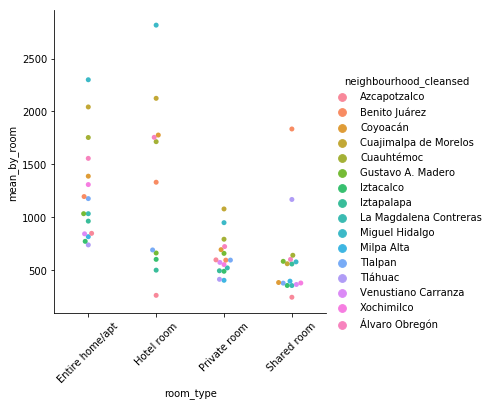

In [86]:
sns.catplot(x="room_type", y="mean_by_room", hue="neighbourhood_cleansed", kind="swarm", data=room_type).set_xticklabels(rotation=45);

In [90]:
room_type.loc[room_type['room_type'] == 'Shared room']

,room_type,neighbourhood_cleansed,mean_by_room
43,Shared room,Azcapotzalco,244.000000
44,Shared room,Benito Juárez,1834.093023
45,Shared room,Coyoacán,383.232558
46,Shared room,Cuajimalpa de Morelos,560.500000
47,Shared room,Cuauhtémoc,640.678832
48,Shared room,Gustavo A. Madero,583.214286
49,Shared room,Iztacalco,355.187500
50,Shared room,Iztapalapa,558.307692
51,Shared room,La Magdalena Contreras,354.666667
52,Shared room,Miguel Hidalgo,578.325581


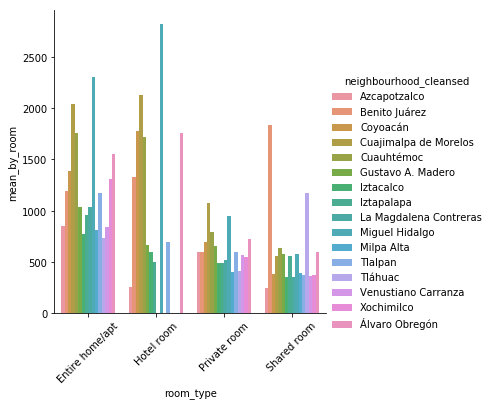

In [92]:
sns.catplot(x="room_type", y="mean_by_room", hue="neighbourhood_cleansed", kind="bar", data=room_type).set_xticklabels(rotation=45);

In [12]:
desc = df.groupby(['neighbourhood_cleansed','room_type'])['price'].mean().unstack(1)

In [13]:
desc

room_type,Entire home/apt,Hotel room,Private room,Shared room
neighbourhood_cleansed,,,,
Azcapotzalco,847.800000,262.000000,597.183544,244.000000
Benito Juárez,1195.391509,1330.888889,594.506603,1834.093023
Coyoacán,1387.924071,1776.769231,693.642311,383.232558
Cuajimalpa de Morelos,2042.205993,2123.909091,1078.395604,560.500000
Cuauhtémoc,1753.561090,1714.218935,792.286778,640.678832
Gustavo A. Madero,1033.666667,662.000000,658.552995,583.214286
Iztacalco,772.331034,602.000000,489.364162,355.187500
Iztapalapa,963.345238,500.000000,2306.748815,558.307692
La Magdalena Contreras,1033.456140,NaN,521.210000,354.666667


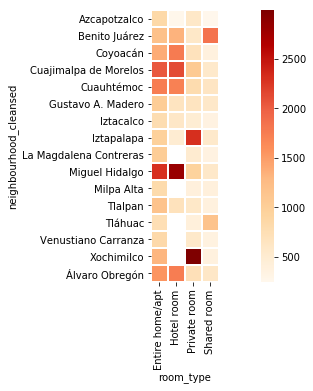

In [14]:
plt.subplots(figsize=(15,5))
sns.heatmap(
    desc, 
    square=True, 
    cbar_kws={'fraction' : 0.3},
    cmap='OrRd',
    linewidth=1 
);

In [15]:
desc.reset_index(level=0, inplace=True)

In [16]:
count = df.groupby(['room_type','neighbourhood_cleansed'])['id'].count().unstack(1)
count = count.T
count.reset_index(level=0, inplace=True)

In [17]:
merged = pd.merge(left=desc, right=count, on='neighbourhood_cleansed')
merged.rename(columns = {'neighbourhood_cleansed':'neighbourhood','Entire home/apt_x':'Entire home/apt mean','Hotel room_x':'Hotel room mean',
                    'Private room_x':'Private room mean','Shared room_x':'Shared room mean','Entire home/apt_y':'Entire home/apt count',
                    'Hotel room_y':'Hotel room count','Private room_y':'Private room count','Shared room_y':'Shared room count'}, inplace = True)
merged

room_type,neighbourhood,Entire home/apt mean,Hotel room mean,Private room mean,Shared room mean,Entire home/apt count,Hotel room count,Private room count,Shared room count
0,Azcapotzalco,847.800000,262.000000,597.183544,244.000000,95.0,1.0,158.0,5.0
1,Benito Juárez,1195.391509,1330.888889,594.506603,1834.093023,1484.0,27.0,1893.0,43.0
2,Coyoacán,1387.924071,1776.769231,693.642311,383.232558,619.0,26.0,1177.0,43.0
3,Cuajimalpa de Morelos,2042.205993,2123.909091,1078.395604,560.500000,267.0,11.0,182.0,6.0
4,Cuauhtémoc,1753.561090,1714.218935,792.286778,640.678832,4919.0,169.0,3222.0,137.0
5,Gustavo A. Madero,1033.666667,662.000000,658.552995,583.214286,120.0,14.0,217.0,14.0
6,Iztacalco,772.331034,602.000000,489.364162,355.187500,145.0,1.0,173.0,16.0
7,Iztapalapa,963.345238,500.000000,2306.748815,558.307692,84.0,1.0,211.0,13.0
8,La Magdalena Contreras,1033.456140,NaN,521.210000,354.666667,57.0,NaN,100.0,3.0
9,Miguel Hidalgo,2299.358835,2815.463415,948.843255,578.325581,2026.0,41.0,1327.0,43.0


In [18]:
home_apt = merged[['neighbourhood','Entire home/apt mean', 'Entire home/apt count']]
home_apt = pd.merge(left = home_apt, right = geop, on = 'neighbourhood')
home_apt.drop(home_apt.columns[[3]], axis=1, inplace=True)
gdf = GeoDataFrame(home_apt, crs = "EPSG:4326", geometry = home_apt.geometry)

colormap = branca.colormap.LinearColormap(
    vmin = gdf['Entire home/apt mean'].quantile(0.0), 
    vmax = gdf['Entire home/apt mean'].quantile(1.0), 
    colors = ['darkgreen','green','lightblue','blue','yellow','orange','red'],
    caption = "Airbnb Entire home/apt mean price by City Hall",
)
m = folium.Map(location = [19.451054, -99.125519], 
               default_zoom_start = 5,
               tiles="Cartodb Positron")

tooltip = GeoJsonTooltip(
    fields = ["neighbourhood","Entire home/apt mean", "Entire home/apt count"],
    aliases = ["City Hall:", "Mean Price:", "Total Accommodations:"],
    localize = True,
    sticky = False,
    labels = True,
    style = """
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)
g = folium.GeoJson(
    gdf,
    style_function=lambda x: {
        "fillColor": colormap(x["properties"]["Entire home/apt mean"])
        if x["properties"]["Entire home/apt mean"] is not None
        else "transparent",
        "color": "black",
        "fillOpacity": 0.4,
    },
    tooltip = tooltip
).add_to(m)

colormap.add_to(m)

m

In [19]:
hotel = merged[['neighbourhood','Hotel room mean', 'Hotel room count']]
hotel = pd.merge(left = hotel, right = geop, on = 'neighbourhood')
hotel.drop(hotel.columns[[3]], axis=1, inplace=True)
gdf = GeoDataFrame(hotel, crs = "EPSG:4326", geometry = home_apt.geometry)

colormap = branca.colormap.LinearColormap(
    vmin = gdf['Hotel room mean'].quantile(0.0), 
    vmax = gdf['Hotel room mean'].quantile(1.0), 
    colors = ['darkgreen','green','lightblue','blue','yellow','orange','red'],
    caption = "Airbnb Hotel room mean price by City Hall",
)
m = folium.Map(location = [19.451054, -99.125519], 
               default_zoom_start = 5,
               tiles="Cartodb Positron")

tooltip = GeoJsonTooltip(
    fields = ["neighbourhood","Hotel room mean", "Hotel room count"],
    aliases = ["City Hall:", "Mean Price:", "Total Accommodations:"],
    localize = True,
    sticky = False,
    labels = True,
    style = """
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)
g = folium.GeoJson(
    gdf,
    style_function=lambda x: {
        "fillColor": colormap(x["properties"]["Hotel room mean"])
        if x["properties"]["Hotel room mean"] is not None
        else "transparent",
        "color": "black",
        "fillOpacity": 0.4,
    },
    tooltip = tooltip
).add_to(m)

colormap.add_to(m)

m

In [20]:
room = merged[['neighbourhood','Private room mean', 'Private room count']]
room = pd.merge(left = room, right = geop, on = 'neighbourhood')
room.drop(room.columns[[3]], axis=1, inplace=True)
gdf = GeoDataFrame(room, crs = "EPSG:4326", geometry = home_apt.geometry)

colormap = branca.colormap.LinearColormap(
    vmin = gdf['Private room mean'].quantile(0.0), 
    vmax = gdf['Private room mean'].quantile(1.0), 
    colors = ['darkgreen','green','lightblue','blue','yellow','orange','red'],
    caption = "Airbnb Private room mean price by City Hall",
)
m = folium.Map(location = [19.451054, -99.125519], 
               default_zoom_start = 5,
               tiles="Cartodb Positron")

tooltip = GeoJsonTooltip(
    fields = ["neighbourhood","Private room mean", "Private room count"],
    aliases = ["City Hall:", "Mean Price:", "Total Accommodations:"],
    localize = True,
    sticky = False,
    labels = True,
    style = """
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)
g = folium.GeoJson(
    gdf,
    style_function=lambda x: {
        "fillColor": colormap(x["properties"]["Private room mean"])
        if x["properties"]["Private room mean"] is not None
        else "transparent",
        "color": "black",
        "fillOpacity": 0.4,
    },
    tooltip = tooltip
).add_to(m)

colormap.add_to(m)

m

In [21]:
shared = merged[['neighbourhood','Shared room mean', 'Shared room count']]
shared = pd.merge(left = shared, right = geop, on = 'neighbourhood')
shared.drop(room.columns[[3]], axis=1, inplace=True)
gdf = GeoDataFrame(shared, crs = "EPSG:4326", geometry = home_apt.geometry)

colormap = branca.colormap.LinearColormap(
    vmin = gdf['Shared room mean'].quantile(0.0), 
    vmax = gdf['Shared room mean'].quantile(1.0), 
    colors = ['darkgreen','green','lightblue','blue','yellow','orange','red'],
    caption = "Airbnb Shared room mean price by City Hall",
)
m = folium.Map(location = [19.451054, -99.125519], 
               default_zoom_start = 5,
               tiles="Cartodb Positron")

tooltip = GeoJsonTooltip(
    fields = ["neighbourhood","Shared room mean", "Shared room count"],
    aliases = ["City Hall:", "Mean Price:", "Total Accommodations:"],
    localize = True,
    sticky = False,
    labels = True,
    style = """
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)
g = folium.GeoJson(
    gdf,
    style_function=lambda x: {
        "fillColor": colormap(x["properties"]["Shared room mean"])
        if x["properties"]["Shared room mean"] is not None
        else "transparent",
        "color": "black",
        "fillOpacity": 0.4,
    },
    tooltip = tooltip
).add_to(m)

colormap.add_to(m)

m

In [5]:
df['host_since'] = pd.to_datetime(df['host_since'])
df['host_since'] = df['host_since'].apply(lambda x: (datetime.now()-x).days)

In [6]:
df.head()

,id,name,host_id,host_since,host_total_listings_count,latitude,longitude,neighbourhood_cleansed,property_type,room_type,square_feet,price,review_scores_rating
0,22787,"Sunny suite w/ queen size bed, inside boutique...",87973,3788,9,19.44076,-99.16324,Cuauhtémoc,Boutique hotel,Private room,248.0,2331.0,98.0
1,35797,Villa Dante,153786,3671,2,19.38399,-99.27335,Cuajimalpa de Morelos,Villa,Entire home/apt,32292.0,4457.0,NaN
2,56074,Great space in historical San Rafael,265650,3558,2,19.43937,-99.15614,Cuauhtémoc,Condominium,Entire home/apt,646.0,809.0,97.0
3,58955,Entire beautiful duplex in la Roma,282620,3537,1,19.42292,-99.15775,Cuauhtémoc,Loft,Entire home/apt,1184.0,1932.0,100.0
4,61792,Spacious Clean Quiet room (own bath) in la Con...,299558,3520,1,19.41259,-99.17959,Cuauhtémoc,House,Private room,161.0,1364.0,98.0


In [7]:
corr_df=df.corr()
heatmap_df=corr_df.drop(['id','host_id','latitude','longitude']).drop(['id','host_id','latitude','longitude'],axis=1)

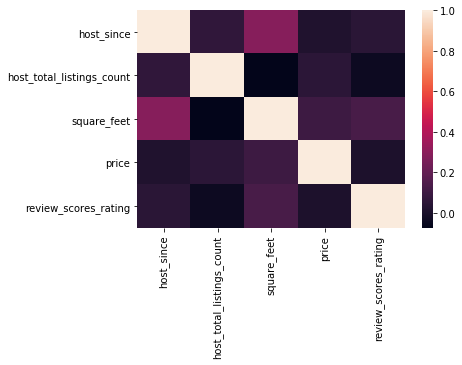

In [8]:
sns.heatmap(heatmap_df);